# Homework 2: Sentiment Classifier

The second programming assignment will familiarize you with the use of machine learning for text
classification, and the use of prebuilt lexicons and bag of words to build custom features.

The primary objective for the assignment is the same as the first assignment: to predict the sentiment of a movie review. We will be providing you with the dataset containing the text of the movie reviews from IMDB, and for each review, you have to predict whether the review is positive or negative.

## Data

The data is the same as the first homework. The filecontains a similar structure for the first homework. 


## Kaggle

As with HW1, you can make at most three submissions each day, so we encourage you to test
your submission files early and observe the performance of your system. By the end of the submission period, you will have to select the two submissions, one for default and one for custom (more on this later).


## Source Code

Some initial code contains methods for loading the data and lexicons, and calling the methods to run and evaluate your classifier. It also contains the code to output the submission file from your classifier (called ```rf_custom_text.csv```) that you will submit to Kaggle. Your directory structure should look like this.
```
hw2  
│
└───code
│    └───hw2_sentiment_classifier.ipynb
│    └───lexicon_reader.py
└───data
│    └───lexicon
│        │   inqtabs.txt
│        └───SentiWordNet_3.0.0_20130122.txt
│    └───test
│        │   0.txt
│        │   1.txt
│        │   ...   
│        └───24999.txt
│    └───train
│        │   0.txt
│        │   1.txt
│        │   ...   
│        └───24999.txt
│    └───train.csv
└───output
```





## What to submit?

Prepare and submit a single write-up ( **PDF, maximum 3 pages** ) with Python source code (custom_features.py, error_analysis.ipynb, and ml_sentiment.py) compressed in a zip file to Canvas. **Do not include your student ID number** , since we might share it with the class if it’s worth highlighting. The write-up pdf and code zip file should be submitted separately on Canvas. The pdf should include:

### Part 1. Preliminaries, 10 points
Kaggle Team name and Kaggle accuracy of best default and custom models. The team with the best score in the competition has 10 points, the 2nd team has 9 points, the third has 8, and the others earn 7 points. You can make ***at most _three_*** submissions each day, so we encourage you to test your submission files early, and observe the performance of your system.

- Start with a single line header: ```Id, Category```
- For each of the unlabeled speech (sorted by name) there is a line containing an increasing integer index (i.e. line number 1), then a comma, and then the string label prediction of that speech.
- See ```sample_sol.csv``` for example.

### Part 2. Default Features, 20 points
Tune classifiers on default features (include the selected range of parameters in the code), and submit your predictions to Kaggle. Include the accuracies of the best classifier for each (LR and RF) and the two plots in the write-up, and a few sentences on how you picked the range.

### Part 3. Custom Features, 35 points
Implement your custom features and vectorizers in the code, and train and tune the classifiers. Submit the predictions to Kaggle, identify the best classifier for each, and include the accuracy obtained in the report. Try at least five different sets of features and vectorizers with at least five other parameters. Include the description and comparison of your features and the vectorizers in a few sentences in the write-up.

### Part 4. Analysis, 30 points
Select the best classifier with default features and the best classifier with custom
features. The analysis will focus on comparing these two classifiers. First, use eli5 to generate the global importance weights for both classifiers in the notebook (show_weights), and in a few sentences in the write-up, describe what is different between them. Then, in the notebook, generate 2 examples each where the classifiers disagree: (i) positive reviews, where only the default is correct, (ii) positive reviews, where only the custom is correct, (iii) negative reviews, where only the default is correct, and (iv) negative reviews, where only the custom is correct. Also, include 2 examples each of when both classifiers are correct, and both are incorrect. In the write-up, include a paragraph describing the insights these errors provide about the differences between the classifiers, especially the advantages/disadvantages of your custom features.

### Part 5. Statement of Collaborations, 5 points

It is mandatory to include a Statement of Collaboration in each submission with respect to the guidelines below. Include the names of everyone involved in the discussions (especially in-person ones) and what was discussed. All students are required to follow the academic honesty guidelines posted on the course website. For programming assignments, in particular, we encourage the students to organize (perhaps using Piazza) to discuss the task descriptions, requirements, bugs in our code, and the relevant technical content before they start working on it. However, you should not discuss the specific solutions, and, as a guiding principle, you are not allowed to take anything written or drawn away from these discussions (i.e., no photographs of the blackboard, written notes, referring to Piazza, etc.). Especially after you have started working on the assignment, try to restrict the discussion to Piazza as much as possible, so that there is no doubt as to the extent of your collaboration.

In [11]:
import sys
import os
import csv
import pickle
import eli5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion, make_pipeline

import lexicon_reader

In [41]:
class Dataset:
    def __init__(self, data, start_idx, end_idx):
        self.data = data
        self.reviews = [row['Review'] for row in data[start_idx:end_idx]]
        self.labels = [row['Category'] for row in data[start_idx:end_idx]]
        self.vecs = None

def get_training_and_dev_data(filedir, dev_rate=0.2):
    with open(os.path.join(filedir, 'train.csv'), 'r', encoding='utf-8') as csvfile:
        data = [row for row in csv.DictReader(csvfile, delimiter=',')]
        for entry in data:
            with open(os.path.join(filedir, 'train', entry['FileIndex'] + '.txt'), 'r', encoding='utf-8') as reviewfile:
                entry['Review'] = reviewfile.read()
    dev_idx = int(len(data) * (1 - dev_rate))
    return Dataset(data, 0, dev_idx), Dataset(data, dev_idx, len(data))

def get_test_data(filedir, output_file_name):
    testfiledir = os.path.join(filedir, 'test')
    with open(output_file_name, 'w', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, delimiter=',', fieldnames=['FileIndex', 'Category'])
        writer.writeheader()
        for filename in sorted(os.listdir(testfiledir), key=lambda x: int(os.path.splitext(x)[0])):
            with open(os.path.join(testfiledir, filename), 'r', encoding='utf-8') as reviewfile:
                fileindex = os.path.splitext(filename)[0]
                review = reviewfile.read()
                yield (fileindex, review)

def write_predictions(filedir, classifier, output_file_name):
    with open(output_file_name, 'w', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, delimiter=',', fieldnames=['FileIndex', 'Category'])
        writer.writeheader()
        for (fileindex, review) in get_test_data(filedir, output_file_name):
            prediction = dict()
            prediction['FileIndex'] = fileindex
            prediction['Category'] = classifier.predict([review])[0]
            writer.writerow(prediction)

def get_trained_classifier(data, model, features):
    ppl = make_pipeline(features, model)
    return ppl.fit(data.reviews, data.labels)

def get_custom_features(filedir):
    return FeatureUnion([
        ('custom_feats', make_pipeline(CustomFeats(filedir), DictVectorizer())),
        ('bag_of_words', get_custom_vectorizer())
    ])

def save(classifier, filedir, output_file_path):
    with open(output_file_path + ".pkl", 'wb') as f:
        pickle.dump(classifier, f)
    write_predictions(filedir, classifier, output_file_path + "_test.csv")

def load_classifier(input_file_path):
    return pickle.load(open(input_file_path, 'rb'))

def plot(xs, train_accuracy_list, dev_accuracy_list, output_file_path=None):
    plt.clf()
    plt.plot(xs, train_accuracy_list, label='train')
    plt.plot(xs, dev_accuracy_list, label='dev')
    plt.ylabel('Accuracy')
    plt.legend()
    if output_file_path is not None:
        plt.savefig(output_file_path)
    else:
        plt.show()

In [13]:
# Load data

filedir = '../data'
print("Reading data")
train_data, dev_data = get_training_and_dev_data(filedir)

Reading data


## Part 2. Default Features
We are providing code for training a machine learning classifier for sentiment classification using unigrams as features, i.e. ```CountVectorizer()```. The first goal is to optimize the hyper-parameters of logistic regression by modifying ```get_tuned_lr```. The regularization weight C is the primary hyper-parameter for logistic regression. Currently, the range for the parameter is ```np.arange(0.5, 3.5, 0.5)``` but this should be modified. When running this function, you will see both training and dev accuracy printed. There will also be a plot ```lr.png``` that will be saved that you can view. Based on these, adjust the range for C. 

The next goal is to optimize the parameters for random forest. To do so, you need to modify ```get_tuned_rf```. ```n_estimators``` is the parameter of interest used by random forest. Currently, the range is set to ```np.arange(5, 35, 5)``` but this should also be modified. Like before, when running this function, you will see both training accuracy and dev accuracy, and the plot ```rf.png``` will be saved. Based on what you see, adjust the parameters accordingly.

Running ```save(tuned_lr, filedir, ‘lr_default’)``` will save the classifier as ```lr_default.pkl``` which you will need for your error analysis. It will also run the classifier on the test set and save the results as ```lr_default_test.csv```, which you can upload to Kaggle. Similarly, the next line will output the files ```rf_default.pkl``` and ```rf_default_test.csv```.

In [134]:
def get_tuned_lr(train, dev, features, output_file_path='./lr.png'):
    train_vecs = features.fit_transform(train.reviews)
    dev_vecs = features.transform(dev.reviews)
    train_accuracy_list = list()
    dev_accuracy_list = list()
    
    # -------------------------------------------------------------------------
    # TODO: You will change this range, or may want to use np.logspace instead of np.arrange
    cs = np.arange(0.025, .1, 0.025)  
    
    for c in cs:
        print(c)
        model = LogisticRegression(C=c)
        model.fit(train_vecs, train.labels)
        train_preds = model.predict(train_vecs)
        dev_preds = model.predict(dev_vecs)
        (train_score, dev_score) = (accuracy_score(train.labels, train_preds), accuracy_score(dev.labels, dev_preds))
        print("Train Accuracy:", train_score, ", Dev Accuracy:", dev_score)
        train_accuracy_list.append(train_score)
        dev_accuracy_list.append(dev_score)
    plot(cs, train_accuracy_list, dev_accuracy_list, output_file_path)
    best_model = LogisticRegression(C=cs[np.argmax(dev_accuracy_list)])
    return get_trained_classifier(train, best_model, features)


def get_tuned_rf(train, dev, features, output_file_path='./rf.png'):
    train_vecs = features.fit_transform(train.reviews)
    dev_vecs = features.transform(dev.reviews)
    train_accuracy_list = list()
    dev_accuracy_list = list()
    
    # -------------------------------------------------------------------------
    # TODO: You will change this range, and try different parameters to tune RF model
    n_estimators = np.arange(50, 1250, 150)
    
    for num_estimator in n_estimators:
        print(num_estimator)
        model = RandomForestClassifier(n_estimators=num_estimator)
        model.fit(train_vecs, train.labels)
        train_preds = model.predict(train_vecs)
        dev_preds = model.predict(dev_vecs)
        (train_score, dev_score) = (accuracy_score(train.labels, train_preds), accuracy_score(dev.labels, dev_preds))
        print("Train Accuracy:", train_score, ", Dev Accuracy:", dev_score)
        train_accuracy_list.append(train_score)
        dev_accuracy_list.append(dev_score)
    plot(n_estimators, train_accuracy_list, dev_accuracy_list, output_file_path)
    best_model = RandomForestClassifier(n_estimators=n_estimators[np.argmax(dev_accuracy_list)])
    return get_trained_classifier(train, best_model, features)

Training model
['1' '1']
Tuning model
Random Forest Models:
50
Train Accuracy: 0.99995 , Dev Accuracy: 0.8356
200
Train Accuracy: 1.0 , Dev Accuracy: 0.8564
350
Train Accuracy: 1.0 , Dev Accuracy: 0.86
500
Train Accuracy: 1.0 , Dev Accuracy: 0.863
650
Train Accuracy: 1.0 , Dev Accuracy: 0.8674
800
Train Accuracy: 1.0 , Dev Accuracy: 0.8618
950
Train Accuracy: 1.0 , Dev Accuracy: 0.8652
1100
Train Accuracy: 1.0 , Dev Accuracy: 0.866


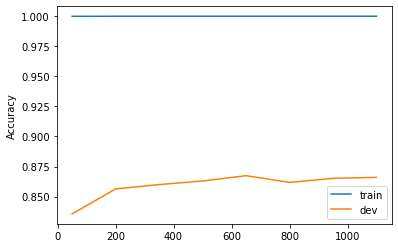

In [147]:
# Some example code to get a trained classifier
print("Training model")
#lr_with_default = get_trained_classifier(train_data, LogisticRegression(), CountVectorizer())
rf_with_default = get_trained_classifier(train_data, RandomForestClassifier(), CountVectorizer())

# You can see some of the predictions of the classifier by running the following code
#print(lr_with_default.predict(["This movie sucks!", "This movie is great!"]))
print(rf_with_default.predict(["This movie sucks!", "This movie is great!"]))

# You can then experiment with tuning the classifiers
# Experiment with the parameters in the get_tuned_lr and get_tuned_rf methods
# Look at the files lr.png and rf.png that are saved after running each of these functions below
print("Tuning model")
#tuned_lr = get_tuned_lr(train_data, dev_data, CountVectorizer())
print("Random Forest Models:")
tuned_rf = get_tuned_rf(train_data, dev_data, CountVectorizer())

# After playing with the parameters and finding a good classifier, you can save
# This will save the classifier to a pickle object which you can then load later from when doing your error analysis
# As well as this will run the classifier on the test set which you can then upload to kaggle
#print("Saving model and predictions")
#save(tuned_lr, filedir, 'lr_default')
#save(tuned_rf, filedir, 'rf_default')


From tuning, the optimal values are 0.1 for c and 950 for n estimators. To speed up the running time, I am recreating the lr anf rf functions below without the for loops. 

In [39]:
#functions without for loops
def lr_default(train, dev, features, output_file_path='./lr.png'):
    train_vecs = features.fit_transform(train.reviews)
    dev_vecs = features.transform(dev.reviews)
    train_accuracy_list = list()
    dev_accuracy_list = list()
    
    model = LogisticRegression(C=0.1)
    model.fit(train_vecs, train.labels)
    train_preds = model.predict(train_vecs)
    dev_preds = model.predict(dev_vecs)
    (train_score, dev_score) = (accuracy_score(train.labels, train_preds), accuracy_score(dev.labels, dev_preds))
    print("Train Accuracy:", train_score, ", Dev Accuracy:", dev_score)
    train_accuracy_list.append(train_score)
    dev_accuracy_list.append(dev_score)
    #plot(0.1, train_accuracy_list, dev_accuracy_list, output_file_path)
    return get_trained_classifier(train, model, features)


def rf_default(train, dev, features, output_file_path='./rf.png'):
    train_vecs = features.fit_transform(train.reviews)
    dev_vecs = features.transform(dev.reviews)
    train_accuracy_list = list()
    dev_accuracy_list = list()
    
    model = RandomForestClassifier(n_estimators=950)
    model.fit(train_vecs, train.labels)
    train_preds = model.predict(train_vecs)
    dev_preds = model.predict(dev_vecs)
    (train_score, dev_score) = (accuracy_score(train.labels, train_preds), accuracy_score(dev.labels, dev_preds))
    print("Train Accuracy:", train_score, ", Dev Accuracy:", dev_score)
    train_accuracy_list.append(train_score)
    dev_accuracy_list.append(dev_score)
    #plot(n_estimators, train_accuracy_list, dev_accuracy_list, output_file_path)
    return get_trained_classifier(train, model, features)

In [40]:
# Some example code to get a trained classifier
print("Training model")
lr_with_default = get_trained_classifier(train_data, LogisticRegression(), CountVectorizer())
rf_with_default = get_trained_classifier(train_data, RandomForestClassifier(), CountVectorizer())

# You can see some of the predictions of the classifier by running the following code
print(lr_with_default.predict(["This movie sucks!", "This movie is great!"]))
print(rf_with_default.predict(["This movie sucks!", "This movie is great!"]))

# You can then experiment with tuning the classifiers
# Experiment with the parameters in the get_tuned_lr and get_tuned_rf methods
# Look at the files lr.png and rf.png that are saved after running each of these functions below
print("Tuning model")
tuned_lr = lr_default(train_data, dev_data, CountVectorizer())
print("Random Forest Models:")
tuned_rf = rf_default(train_data, dev_data, CountVectorizer())

# After playing with the parameters and finding a good classifier, you can save
# This will save the classifier to a pickle object which you can then load later from when doing your error analysis
# As well as this will run the classifier on the test set which you can then upload to kaggle
#print("Saving model and predictions")
#save(tuned_lr, filedir, 'lr_default')
#save(tuned_rf, filedir, 'rf_default')

Training model


/Users/marinannacarini/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['0' '1']
['0' '1']
Tuning model


/Users/marinannacarini/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 0.97155 , Dev Accuracy: 0.892


/Users/marinannacarini/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest Models:
Train Accuracy: 1.0 , Dev Accuracy: 0.8678


ValueError: dict contains fields not in fieldnames: 'Id'

In [42]:
print("Saving lr")
save(tuned_lr, filedir, 'lr_default')
print("Saving rf")
save(tuned_rf, filedir, 'rf_default')

Saving lr
Saving rf


## Part 3. Custom Features and Vectorizers
The next goal for the assignment is to improve upon these classifiers by introducing your own features. Similar to the in-class activity in week 4, you will design features that utilize lexicons and regular expressions, etc., and ```experiment with the vectorizer``` (e.g., unigrams vs. bigrams, counts vs. TF-IDF, etc.). To implement
these ```features```, you will need to modify the features function, and you can change
the ```vectorizer```.

As before, tune the parameters for both logistic regression and random forest, but this time with your custom features. 

Run the save methods to save the classifiers (```lr_custom.pkl``` and ```rf_custom.pkl```) and predictions (```lr_custom_text.csv``` and ```rf_custom_text.csv```), and upload the latter files to Kaggle.

In [30]:
from afinn import Afinn
#!pip install afinn

af = Afinn()

import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
import operator
from textblob import TextBlob

In [126]:
class CustomFeats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""
    def __init__(self, filedir):
        self.feat_names = set()
        lexicon_dir = os.path.join(filedir, 'lexicon')
        self.inqtabs_dict = lexicon_reader.read_inqtabs(os.path.join(lexicon_dir, 'inqtabs.txt'))
        self.swn_dict = lexicon_reader.read_senti_word_net(os.path.join(lexicon_dir, 'SentiWordNet_3.0.0_20130122.txt'))

    def fit(self, x, y=None):
        return self

    @staticmethod
    def word_count(review):
        #clean up text
        regex_clean_html = re.compile(r'<.*?>') # Locate any HTML tags
        html_clean = re.sub(regex_clean_html, '', review) # Replace any HTML tags w/ blank
        split = html_clean.split(' ') # Split sentences into single word
        words = [x.lower() for x in split] # Lowercase 
        return len(words)
        words = review.split(' ')
        return len(words)

    def pos_count(self, review):
        #clean up text
        regex_clean_html = re.compile(r'<.*?>') # Remove any HTML tags
        html_clean = re.sub(regex_clean_html, '', review) # Replace any HTML tags w/ blank
        split = html_clean.split(' ') # Split sentences into single word
        words = [x.lower() for x in split] # Lowercase
        count = 0
        for word in words:
            if word in self.inqtabs_dict.keys() and self.inqtabs_dict[word] == lexicon_reader.POS_LABEL:
                count += 1
        return count
    
    def neg_count(self, review):
        #clean up text
        regex_clean_html = re.compile(r'<.*?>') # Remove any HTML tags
        html_clean = re.sub(regex_clean_html, '', review) # Replace any HTML tags w/ blank
        split = html_clean.split(' ') # Split sentences into single word
        words = [x.lower() for x in split] # Lowercase
        count = 0
        for word in words:
            if word in self.inqtabs_dict.keys() and self.inqtabs_dict[word] == lexicon_reader.NEG_LABEL:
                count += 1
            elif word in self.swn_dict.keys() and self.swn_dict[word] == lexicon_reader.NEG_LABEL:
                count += 1
            elif af.score(word) <0:
                count += 1
        return count

    def afinn_pos_count(self, review):
        #clean up text
        regex_clean_html = re.compile(r'<.*?>') # Remove any HTML tags
        html_clean = re.sub(regex_clean_html, '', review) # Replace any HTML tags w/ blank
        split = html_clean.split(' ') # Split sentences into single word
        words = [x.lower() for x in split] # Lowercase
        count = 0
        for word in words:
            if af.score(word) > 0:
                count += 1
        return count
    
    def afinn_neg_count(self, review):
        #clean up text
        regex_clean_html = re.compile(r'<.*?>') # Remove any HTML tags
        html_clean = re.sub(regex_clean_html, '', review) # Replace any HTML tags w/ blank
        split = html_clean.split(' ') # Split sentences into single word
        words = [x.lower() for x in split] # Lowercase
        count = 0
        for word in words:
            if af.score(word) < 0:
                count += 1
        return count
    
    def features(self, review):
        return {
            # -------------------------------------------------------------------------
            # 4 example features 
            # TODO: Add your own here e.g. word_count, and pos_count
            #neg word count
            #afinn method
            
            'length': len(review),
            'num_sentences': review.count('.'),
            'num_words': self.word_count(review),
            'pos_count': self.pos_count(review),
            
            #added features
            'num_exclaimations': review.count('!'),
            'afinn_pos': self.afinn_pos_count(review),
            'afinn_neg': self.afinn_neg_count(review),
            'neg_count': self.neg_count(review),
            'textblob_polarity': TextBlob(review).sentiment[0],
            'textblob_subjectivity': TextBlob(review).sentiment[1]
            
        }

    def get_feature_names(self):
        return list(self.feat_names)

    def transform(self, reviews):
        feats = []
        for review in reviews:
            f = self.features(review)
            [self.feat_names.add(k) for k in f]
            feats.append(f)
        return feats


def get_custom_vectorizer():
    # -------------------------------------------------------------------------
    #TODO: Experiment with different vectorizers
    return CountVectorizer(stop_words={'english'}, min_df=3, max_df=5400, ngram_range=(2,2))


In [60]:
# Experiment with different features by modifiying custom_features.py and test your accuracy by running:
# (Again, you can look at the lr.png  and rf.png that are saved after running each of these functions)
print("Tuning model")
tuned_lr_custom = get_tuned_lr(train_data, dev_data, get_custom_features(filedir))
#tuned_rf_custom = get_tuned_rf(train_data, dev_data, get_custom_features(filedir))

#print("Saving model and predictions")
#save(tuned_lr_custom, filedir, 'lr_custom')
#save(tuned_rf_custom, filedir, 'rf_custom')

Tuning model


KeyboardInterrupt: 

In [54]:
#functions without for loops
def lr_custom(train, dev, features, output_file_path='./lr.png'):
    #train_vecs = features.fit_transform(train.reviews)
    #dev_vecs = features.transform(dev.reviews)
    train_accuracy_list = list()
    dev_accuracy_list = list()
    
    model = LogisticRegression(C=0.1)
    model.fit(train_vecs, train.labels)
    train_preds = model.predict(train_vecs)
    dev_preds = model.predict(dev_vecs)
    (train_score, dev_score) = (accuracy_score(train.labels, train_preds), accuracy_score(dev.labels, dev_preds))
    print("Train Accuracy:", train_score, ", Dev Accuracy:", dev_score)
    train_accuracy_list.append(train_score)
    dev_accuracy_list.append(dev_score)
    #plot(0.1, train_accuracy_list, dev_accuracy_list, output_file_path)
    return get_trained_classifier(train, model, features)


def rf_custom(train, dev, features, output_file_path='./rf.png'):
    #train_vecs = features.fit_transform(train.reviews)
    #dev_vecs = features.transform(dev.reviews)
    train_accuracy_list = list()
    dev_accuracy_list = list()
    
    model = RandomForestClassifier(n_estimators=950)
    model.fit(train_vecs, train.labels)
    train_preds = model.predict(train_vecs)
    dev_preds = model.predict(dev_vecs)
    (train_score, dev_score) = (accuracy_score(train.labels, train_preds), accuracy_score(dev.labels, dev_preds))
    print("Train Accuracy:", train_score, ", Dev Accuracy:", dev_score)
    train_accuracy_list.append(train_score)
    dev_accuracy_list.append(dev_score)
    #plot(n_estimators, train_accuracy_list, dev_accuracy_list, output_file_path)
    return get_trained_classifier(train, model, features)

In [174]:
cust_features = CountVectorizer(stop_words={'english'}, min_df=3, max_df=5400, ngram_range=(2,2))

train_vecs = cust_features.fit_transform(train_data.reviews)
dev_vecs = cust_features.transform(dev_data.reviews)

print("Tuning model")
#tuned_lr_custom = lr_custom(train_data, dev_data, get_custom_features(filedir))
tuned_rf_custom = rf_custom(train_data, dev_data, get_custom_features(filedir))

#print("Saving lr model and predictions")
#save(tuned_lr_custom, filedir, 'lr_custom')
print("Saving rf model and predictions")
save(tuned_rf_custom, filedir, 'rf_custom')

Tuning model


KeyboardInterrupt: 

## Part 4. Error Analysis
Along with tuning classifiers and designing features to achieve as high of accuracy as possible, you also need to perform an analysis of the classifier in this assignment. For this analysis, modify the function to get metrics and feature weights for all four of your best classifiers (note, it is currently set up to only compute metrics for two, so you will need to either modify it to get metrics for all four or run it twice). You may need to update ```load_classifier(’lr_default.pkl’)``` replacing ```lr_default.pkl``` with the model you have (the one that was saved when you run the saved method earlier).

The rest of the notebook also contains the two primary approaches for analysis that use the ```eli5``` package: (1) global importance weights of individual classifiers, and (2) weights of individual words, for example, predictions. The notebook also includes code for easily comparing classifiers to each other.

In [136]:
pd.set_option('display.max_colwidth', -1)

def get_error_type(pred, label):
    # return the type of error: tp,fp,tn,fn
    if pred == label:
        return "tp" if pred == '1' else "tn"
    return "fp" if pred == '1' else "fn"

# Change this for your different classifiers
classifier1 = load_classifier('lr_default.pkl')
classifier2 = load_classifier('rf_default.pkl')
classifier3 = load_classifier('lr_custom.pkl')
classifier4 = load_classifier('rf_custom.pkl')

# Create pandas dataframe
predictions = pd.DataFrame.from_dict(dev_data.data)

# Classify data points using classifier1
predictions['Classifier1Prediction'] = classifier1.predict(predictions['Review'])
predictions['Classifier1ErrorType'] = predictions.apply(lambda row: get_error_type(row['Classifier1Prediction'], row['Category']), axis=1)

# Classify data points using classifier 2
predictions['Classifier2Prediction'] = classifier2.predict(predictions['Review'])
predictions['Classifier2ErrorType'] = predictions.apply(lambda row: get_error_type(row['Classifier2Prediction'], row['Category']), axis=1)

# Classify data points using classifier 3
predictions['Classifier3Prediction'] = classifier3.predict(predictions['Review'])
predictions['Classifier3ErrorType'] = predictions.apply(lambda row: get_error_type(row['Classifier3Prediction'], row['Category']), axis=1)

# Classify data points using classifier 4
predictions['Classifier4Prediction'] = classifier4.predict(predictions['Review'])
predictions['Classifier4ErrorType'] = predictions.apply(lambda row: get_error_type(row['Classifier4Prediction'], row['Category']), axis=1)

# Get metrics for each classifier
def print_metrics(error_type_counts):
    accuracy = (error_type_counts['tp'] + error_type_counts['tn']) / sum(error_type_counts)
    precision = error_type_counts['tp'] / (error_type_counts['tp'] + error_type_counts['fp'])
    recall = error_type_counts['tp'] / (error_type_counts['tp'] + error_type_counts['fn'])
    print("Accuracy:", accuracy, "\nPrecision:", precision, "\nRecall:", recall, "\nF1:", 2 * precision*recall/(precision + recall))

print("Classifier1 Metrics")
print_metrics(predictions['Classifier1ErrorType'].value_counts())
print("\nClassifier2 Metrics")
print_metrics(predictions['Classifier2ErrorType'].value_counts())
print("\nClassifier3 Metrics")
print_metrics(predictions['Classifier3ErrorType'].value_counts())
print("\nClassifier4 Metrics")
print_metrics(predictions['Classifier4ErrorType'].value_counts())

<ipython-input-136-e364d8229e7a>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Classifier1 Metrics
Accuracy: 0.95564 
Precision: 0.9551666267082235 
Recall: 0.95616 
F1: 0.9556630552112901

Classifier2 Metrics
Accuracy: 0.973 
Precision: 0.969506868895418 
Recall: 0.97672 
F1: 0.9731000677479775

Classifier3 Metrics
Accuracy: 0.8074 
Precision: 0.8115119578435347 
Recall: 0.8008 
F1: 0.8061203946043889

Classifier4 Metrics
Accuracy: 0.97056 
Precision: 0.9702590342181004 
Recall: 0.97088 
F1: 0.9705694177863083


In [137]:
eli5.show_weights(classifier1, top=25)

In [138]:
eli5.show_weights(classifier2, top=25)

Weight,Feature
0.0097 ± 0.0239,bad
0.0082 ± 0.0203,worst
0.0060 ± 0.0133,great
0.0049 ± 0.0130,waste
0.0046 ± 0.0118,awful
0.0040 ± 0.0043,and
0.0039 ± 0.0091,no
0.0033 ± 0.0088,excellent
0.0030 ± 0.0075,boring
0.0030 ± 0.0022,the


In [139]:
eli5.show_weights(classifier3, top=25)

/Users/marinannacarini/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


In [140]:
eli5.show_weights(classifier4, top=25)

Weight,Feature
0.0412 ± 0.1134,custom_feats:textblob_polarity
0.0149 ± 0.0416,custom_feats:afinn_neg
0.0121 ± 0.0341,custom_feats:neg_count
0.0085 ± 0.0190,custom_feats:afinn_pos
0.0065 ± 0.0201,bag_of_words:the worst
0.0030 ± 0.0055,custom_feats:pos_count
0.0027 ± 0.0087,bag_of_words:waste of
0.0026 ± 0.0042,custom_feats:num_words
0.0026 ± 0.0039,custom_feats:length
0.0025 ± 0.0080,bag_of_words:the best


In [149]:
#Comparing rf default and rf custom models for false negatives
predictions[predictions['Classifier2ErrorType'] == 'fn'].sample(10)

# See where they disagree
# Modify the code to find cases where one classifier's prediction is correct but the other is incorrect
predictions['ClassifiersAgree'] = predictions['Classifier2Prediction'] == predictions['Classifier4Prediction']
disagreements = predictions[predictions['ClassifiersAgree'] == False]
print("# Cases where the two classifiers disagree:", len(disagreements), "->", len(disagreements) / len(predictions) * 100, "%")
disagreements.sample(10)

# Cases where the two classifiers disagree: 587 -> 2.348 %


,FileIndex,Category,Review,Classifier1Prediction,Classifier1ErrorType,Classifier2Prediction,Classifier2ErrorType,Classifier3Prediction,Classifier3ErrorType,Classifier4Prediction,Classifier4ErrorType,ClassifiersAgree
22241,22241,0,"I've been reading posts here concerning Wonder Woman's costume for this TV movie. It should be pointed out at the time the movie was made, she wasn't wearing her traditional outfit. The producers were actually sticking to the comic book writer's conception of WW for the early seventies.<br /><br />As for the movie itself, I have to agree with many of the other posters here. Snoozefest! I was a kid when it appeared on ABC in 1974, so I was at the right age to have appreciated a movie about a comic book hero. Yet I was so ""engrossed"" with the plot, I stopped watching it three quarters into the movie.<br /><br />Of course, I wasn't at the right age to appreciate Cathy Lee! :-)",0,tn,0,tn,1,fp,1,fp,False
20008,20008,1,"Ooverall, the movie was fairly good, a good action plot with a fair amount of explosions and fight scenes, but Chuck Norris did hardly anything, except for disarm the bomb and shoot a few characters. The movie was very similar to the events of Sept. 11, with a bin laden-like terrorist sending a video to the president (Urich) and threatening to detonate it. Judson Mills had some superb action roles, taking out Rashid's compound and various kick-butt roles but, there was a lack of Chuck Norris. Judson took over most of the action, leaving Joshua (chuck) with Que on her computer. But, overall, it was realistic and didn't lack the action, but only did it on Mr. Norris' part. I gave the film 7/10.",0,fn,1,tp,0,fn,0,fn,False
21337,21337,0,"This crew-versus-monsta has been done a hundred times, sometimes better. This one was pretty slow-moving ; only the monster's resurrection was really worthwhile. Attempts at character developments gets botched by routine. Yeah, ""routine"" is the word. Went straight to video in France. No wonder",0,tn,0,tn,1,fp,1,fp,False
24910,24910,1,"In the immortal ""Shaun of the Dead"", we are introduced to a London where the slackers and the high-and-mighty alike are forced to battle flesh-eating, reanimated corpse versions of their friends and family. At the end of the film, it is suggested that the zombies are rendered harmless and used as cheap labour. ""Fido"" presents us with an epilogue to ""Shaun"" set in 1950's America, in a hilariously witty and original ""what-if...?"" movie.<br /><br />The film is set post-zombie-apocalypse, for a change; after the terrors of the Zombie Wars, ended by the creation of the ZomCon company and their patented zombie collars which make the corpses as docile as lambs. Every town in the world is fenced off from the Wild Zone, the once-fertile landscape torn asunder by the surviving zombies and left-overs from the apocalyptic wars. The idyllic town of Willard is your typical, pristine 50's suburbia, with one small difference; social status is measured by a family's amount of domesticated zombies. Unfortunately, the Robinson family has no zombies whatsoever, due to their patriarch, Bill's, fear of the reanimated dead. Timmy Robinson and his mother Helen both suffer from the pressures of suburban life, until the day that Helen purchases a zombie servant in a desperate attempt to impress the neighbours.<br /><br />The zombie earns Timmy's love when he rescues him from a pair of violent bullies, and the two form a bond to rival the classic ""boy-and-his-dog"" cliché... a boy and his zombie. Timmy names his ""pet"" Fido, and he soon becomes an aid for both Timmy and Helen to escape the prison-like routine Bill has put them in. But when Fido's domestication collar goes on the fritz and he devours the elderly Mrs Henderson, the Robinsons have to contain their connection the sudden wild zombie epidemic and still manage to keep their beloved Fido.<br /><br />A film whose sharp wit and satirical gore carry it just as much as its all-star cast 

In [150]:
#Comparing rf default and rf custom models for false positive
predictions[predictions['Classifier2ErrorType'] == 'fp'].sample(10)

# See where they disagree
# Modify the code to find cases where one classifier's prediction is correct but the other is incorrect
predictions['ClassifiersAgree'] = predictions['Classifier2Prediction'] == predictions['Classifier4Prediction']
disagreements = predictions[predictions['ClassifiersAgree'] == False]
print("# Cases where the two classifiers disagree:", len(disagreements), "->", len(disagreements) / len(predictions) * 100, "%")
disagreements.sample(10)

# Cases where the two classifiers disagree: 587 -> 2.348 %


,FileIndex,Category,Review,Classifier1Prediction,Classifier1ErrorType,Classifier2Prediction,Classifier2ErrorType,Classifier3Prediction,Classifier3ErrorType,Classifier4Prediction,Classifier4ErrorType,ClassifiersAgree
24286,24286,1,"A mess of genres but it's mainly based on Stephen Chow's genre mash-ups for it's inspiration. There's magic kung-fu, college romance, sports, gangster action and some weepy melodrama for a topping. The production is excellent and the pacing is fast so it's easy to get past the many flaws in this film.<br /><br />A baby is abandoned next to a basketball court. A homeless man brings him to a Shaolin monastery that's in the middle of a city along with a special kung fu manual that the homeless man somehow has but can't read. The old monk teaches the boy but expires when he tries to master the special technique in the manual. The school is taken over by a phony kung fu master who is assisted by four wacky monks. The new master gets mad at the now 20+ year old boy for not pretending to be hurt by the master's weak punches and throws him out for the night. The boy is found throwing garbage into a basket from an incredible distance by a man who bring him to a gangster's club to play darts. This leads to a big fight, the boy's expulsion from the monastery and the man's decision to turn the boy into a college basketball sensation.<br /><br />Al this happens in the first 20 minutes with most of it happening in the first 10 minutes. Aside from the extreme shorthand storytelling the first problem is how little we get to know the main character until way into the movie. The man who uses the boy is more sharply defined by the time the first third is over. The plot follows no new ground except for the insane action climax of the film. I'm sure you can easily imagine how the wacky monks will show up towards the end. The effects, photography and stunt work are all top- notch and make up for the uninspired plot. <br /><br />Stephen Chow has a much better command of plot and comedy writing and this film will live in his shadow but that's not a good reason to ignore it. It's quite entertaining even with a scatter-shot ending. Recommended.",1,tp,1,tp,0,fn,0,fn,False
23136,23136,0,"...when he remade Broadway BILL (1934) as RIDING HIGH (1950). Recasting Bing Crosby as DAN BROOKS did not help a screenplay that was 'dated' in 34 let alone 50. This sad film has entire scenes lifted from the original with many of the supporting cast repeating their roles, unless they were dead. Though being older did not seem to matter to the Director. Nor that the Cars and Clothes in the background plates from 1934 did not seem match up too 1950s' standards. Not even 'der Bingel' singing can redeem this effort.<br /><br />We rated both the original and the remake IMDb Four****Stars. Frank's touch was long gone and all that was left was CAPRA-CORN. That did not stop Mr. Capra though. After floundering around the 50's making some educational documentaries he wound up his career remaking LADY FOR A DAY (1933) as POCKETFUL OF MIRACLES (1961). Again a fine cast was let down on that IMDb Six******Star effort compared too the originals Eight********Stars. Sometimes it is better to quit while you were still ahead, right after STATE OF THE UNION (1948).",0,tn,1,fp,1,fp,0,tn,False
21162,21162,0,"After mob boss Vic Moretti (late great Anthony Franciosa) kills his lady whom has been cheating on him with Derek, their new chauffeur/ Vietnam vet, and blames it on the poor guy, Derek finds himself in jail where he has to contend with a corrupt warden, Vic's prisoner brother who runs the jail, and, oh yeah illegal experiments conducted by a shady CIA agent (great genre-mainstay and first time director John Saxon) to turn various prisoners into super-human invincible zombies. Of course things get out of hand and it's up to Derek, and the rest of the unchanged prisoners, to save the day after the infected ones take the jail over.<br /><br />John Saxon is a grea

In [151]:
#Comparing rf detault and rf custom models for true positive
predictions[predictions['Classifier2ErrorType'] == 'tp'].sample(10)

# See where they disagree
# Modify the code to find cases where one classifier's prediction is correct but the other is incorrect
predictions['ClassifiersAgree'] = predictions['Classifier2Prediction'] == predictions['Classifier4Prediction']
agreements = predictions[predictions['ClassifiersAgree'] == True]
print("# Cases where the two classifiers agree:", len(agreements), "->", len(agreements) / len(predictions) * 100, "%")
agreements.sample(10)

# Cases where the two classifiers agree: 24413 -> 97.652 %


FileIndex Category  \
6436   6436      1         
15680  15680     1         
17761  17761     1         
22670  22670     1         
8930   8930      1         
2390   2390      0         
10898  10898     0         
15829  15829     0         
12099  12099     0         
15328  15328     1         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [152]:
#Comparing rf detault and rf custom models for true negative
predictions[predictions['Classifier2ErrorType'] == 'tn'].sample(10)

# See where they disagree
# Modify the code to find cases where one classifier's prediction is correct but the other is incorrect
predictions['ClassifiersAgree'] = predictions['Classifier2Prediction'] == predictions['Classifier4Prediction']
agreements = predictions[predictions['ClassifiersAgree'] == True]
print("# Cases where the two classifiers agree:", len(agreements), "->", len(agreements) / len(predictions) * 100, "%")
agreements.sample(10)

# Cases where the two classifiers agree: 24413 -> 97.652 %


,FileIndex,Category,Review,Classifier1Prediction,Classifier1ErrorType,Classifier2Prediction,Classifier2ErrorType,Classifier3Prediction,Classifier3ErrorType,Classifier4Prediction,Classifier4ErrorType,ClassifiersAgree
15421,15421,0,"This movie is an embarrassment to film-making. I can't believe it was even listed as a comedy - not funny. Not only was the script atrocious, but the casting people should be shot. Gail O'Grady is just a great actress, but beyond that... %99 of the rest of the cast...ouch. Pretty much everyone else...wow it is hard to even...wow. Here is the number one rule about comedy ""DON'T TRY TO BE FUNNY"". There are a lot of very talented actors in Canada who can do drama and comedy - none of them were used in this film. Canadian nepotism and casting directors are helping to perpetuate bad film-making in Canada. I realize this is technically a ""US"" film, but look at the director, actors, location, etc. I just saw this on Bravo - they should be ashamed that they bought the rights to show this film. Again, there are a lot of great films out there that can't get airtime and they show this crap.",0,tn,0,tn,0,tn,0,tn,True
1168,1168,0,"With a title like that, it's above and beyond my comprehension how this movie just did NOT appeal to me. Granted, there's a few decently sleazy moments and a little gore, but the way in which the movie was shot and the overall storyline just struck me as an idiotic and lazy attempt at profuse ""shock"" tactics... The inconsistent plot starts with a guy raping and murdering a woman stranded at the side of the road. He and his abetting brother are imprisoned up until the brother breaks out and arranges to meet his girlfriend out in the woods. He ends up forcing her into a house where they screw and he later shows her a collection of kidnapped guys in the basement. The heavily drugged captives consist of her old boyfriend who raped her, a ""grabby"" neighbor, and her sexually abrasive boss. He explains to her that he is going to kill them all. She winds up killing HIM and then turning her focus towards the men (or pigs) whom she tortures and kills, herself... Most of the violence and humiliation has to do with sh!t eating and genitalia destroying - all of which are far from disturbing and essentially mild. The best scene is a graphic broom handle masturbation followed by some painful man-rape... Surely, ""I Spit on Your Corpse, I P!ss on Your Grave"" was intended as an unofficial sequel to ""I Spit on Your Grave"" - based on, mainly the title, and a reference the main character gives - suggesting her mother was Camille Keaton. I personally consider that to be a wildly blasphemous assertion! This movie is a boring, amateurish mess that strives for shocks but failed miserably...",0,tn,0,tn,0,tn,0,tn,True
5171,5171,0,"While most of the movie is very amateurish, the Kosher slaughter scene is played up, but not untrue. Kosher law says that an animal must be conscious when the blade touches it's skin. The Kosher slaughter scene is accurate as anyone knows who has seen one, or has seen the Peta film showing a Kosher slaughter, in which the animals throat is cut, and the esophagus cut out while it is still alive, conscious, and obviously suffering. We must remember that history is written by the victors. Is one even Allowed to even THINK that maybe the Nazis were right??<br /><br />Doesn't it say anything that the Nazis had outlawed this vicious religious slaughter, and the Jews are still practicing it even today?",1,fp,0,tn,0,tn,0,tn,True
12799,12799,0,"If you are the sort of person who can get a kick out of a very bad movie, then I highly recommend this one. If you aren't, stay away. This is an astonishingly cheap-looking movie, and at times you may find yourself wondering if it isn't just a prank someone is pulling on you. The most positive comment I can make about it is that the people responsible seemed to realize that it was super-low-budget nonsense, so there is at least a sense of fun 

In [185]:
#Both TP
predictions[(predictions['Classifier2ErrorType'] == 'tp') & (predictions['Classifier4ErrorType'] == 'tp')]

FileIndex Category  \
1      1         1         
4      4         1         
5      5         1         
6      6         1         
9      9         1         
...   ..        ..         
24987  24987     1         
24991  24991     1         
24994  24994     1         
24995  24995     1         
24998  24998     1         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [187]:
#Both FP
predictions[(predictions['Classifier2ErrorType'] == 'fp') & (predictions['Classifier4ErrorType'] == 'fp')]

,FileIndex,Category,Review,Classifier1Prediction,Classifier1ErrorType,Classifier2Prediction,Classifier2ErrorType,Classifier3Prediction,Classifier3ErrorType,Classifier4Prediction,Classifier4ErrorType,ClassifiersAgree
20002,20002,0,"Much like the early horror film The Boogens, the devious unseen killer is quite a letdown when it finally becomes seen. Although Animal House's Stephen Furst obviously had fun in the role as a product of incest, his performance is more comedy than horror.<br /><br />The plot, an extremely tired one, has three sexy women(Bach, Lamm and Lois Young) unable to find a hotel for the evening, so they willingly accept to stay with a seemingly kind museum curator, exceptionally played by the deceased Sydney Lassick. If you have ever seen any horror film, you know that lovable IL' Sydney is a deranged psycho, so one knows what will happen to the lovely ladies.<br /><br />The three women are all very attractive, especially Barbara Bach, but Lois Young(a Helen Hunt clone) is the only one to go nude, as Sydney watches her take a bath.",1,fp,1,fp,1,fp,1,fp,True
20018,20018,0,"Take young, pretty people, put them in an exotic locale, stick in a few bad guys, have the two lead characters find romance after a couple of heavy breathing scenes, create the flimsiest of plots, then work out a happy ending for everybody (other than the three or four who get murdered, of course) That's the classic (and successful) format of the Harlequin Romance. It's not very good but then it's not very bad either, like most of the little yellow pocket books. And the location stuff in Budapest is especially interesting, even if they didn't use the wonderful old train station (designed by Gustave Eifel) or show the city's famous thermal baths.",0,tn,1,fp,1,fp,1,fp,True
20024,20024,0,"An excellent performance by Alix Elias highlights an otherwise mis-directed and confused pile of dreck. I have seen this movie, perhaps 12 times, and with each run through, I find less and less pleasure. Why are Munchies so lustful? Is that ever explained? Are they a reflection of our wanton, boorish 'animal selves?' If they are, why not make it more obvious? Why not peal back just a touch of the subtlety that plagues this movie, and make that connection explicit? Another part of this movie that bothers me to no end - motorcycles. The jacket the little monster wears on the front cover seems to suggest 'street-wise' traveler. The sun glasses say 'pretty cool dude.' With all this I'm ready for Easy Rider meets the Muppets. All I get is Munchies (1987). What gives? Stick to the Gremlins series if you're a fan of diminutive, wise-cracking, reptile puppets - it'll give you the treatment you deserve.",0,tn,1,fp,1,fp,1,fp,True
20046,20046,0,"""Laugh, Clown Laugh"" released in 1928, stars the legendary Lon Chaney as a circus clown named Tito. Tito has raised a foundling (a young and beautiful Loretta Young) to adulthood and names her Simonetta. Tito has raised the girl in the circus life, and she has become an accomplished ballerina. While Chaney gives his usual great performance, I could not get past the fact that Tito, now well into middle age, has the hots for the young Simonetta. Although he is not her biological father, he has raised her like a daughter. That kind of ""ick"" factor permeates throughout the film. Tito competes for Simonetta's affections with a young and handsome 'Count' Luigi (Nils Asther). Simonetta clearly falls for the young man, but feels guilt about abandoning Tito (out of loyalty, not romantic love). The whole premise of the film is ridiculous, and I find it amazing that no one in the film tells Tito what a stupid old fool he is being (until he reveals it himself at the end). The film is noteworthy only because of Loretta Young, who would go on to have a great career. While I adore Chaney's brilliance as an actor, this whole film seems off to me and just downright creepy.",1,fp,1,fp,1,fp,1,fp,True
20083,20083,0,"Merry madcaps in London stage 

In [186]:
#Both TN
predictions[(predictions['Classifier2ErrorType'] == 'tn') & (predictions['Classifier4ErrorType'] == 'tn')]

,FileIndex,Category,Review,Classifier1Prediction,Classifier1ErrorType,Classifier2Prediction,Classifier2ErrorType,Classifier3Prediction,Classifier3ErrorType,Classifier4Prediction,Classifier4ErrorType,ClassifiersAgree
0,0,0,"This show is terrible, the jokes are all terrible and just getting worse and worse. I am one of those people who was never a big fan of Corner Gas but at least I liked it at first until it got into a rut around season two, all the jokes had been played out and the characters had nothing to them. Well at least Corner Gas was good at first, Little Mosque on the Prairie is typically awful bland CBC comedy that had nothing going for it from episode 1. Who are the people who are watching this show anyway, I am being honest is it old people or maybe just people who actually live on the prairies? Maybe the jokes are for them and they work there? I don't know a single person who likes this show and can't stand it myself, the jokes are totally predictable and the characters are even less developed than in Corner Gas. Hopefully it won't last much longer because all the success this show has had seems to me to be based entirely on the premise of this show being Muslim which is different and could/should have led to a great show.",0,tn,0,tn,1,fp,0,tn,True
2,2,0,"Although I had seen ""Gymkata"" in a theater way back in '85, I couldn't remember anything of the plot except for vague images of Kurt Thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending.<br /><br />After reading some of the other reviews I picked up a copy of the newly released DVD to once again enter the world of Gymkata.<br /><br />It turns out this is one of those films produced during the '80s that would go directly to video today. The film stars champion gymnast Kurt Thomas as Jonathan Cabot, recruited out of the blue to infiltrate the nation of ""Parmistan"" to enter and hopefully win ""The Game,"" a suicidal bloodsport sponsored by the Khan who encourages his people by yelling what sounds like ""Yak Power."" The goal of the mission involves the Star Wars defense system. Jonathan is trained in the martial arts by Princess Rubali, who never speaks or leaves the house. Once trained tries to blend in with the locals by wearing a bright red sweater with dashes of blue and white. Needless to say Cabot finds himself running and fighting for his life along the stone streets of Parmistan, on his way to a date with destiny, and the Game.<br /><br />Star, Kurt Thomas was ill served by director Robert Clouse, who it looks like was never on the set. The so called script is just this side of incompetent. See other reviews for the many howlers throughout. The town of crazies has a few good moments, but is ultimately ruined by bad editing. The ending...meh. Still there's the germ of a good action adventure here. A Hong Kong version with more visceral action and faster pace might even be pretty good.",0,tn,0,tn,1,fp,0,tn,True
3,3,0,"This sequel is thoroughly uneven, incoherent and rambling in ""plot"" (if there really is one)and tries too damned hard to be modern (ridiculous, out of period and character 21 st century style songs predominate) and cute (yawn: there are too many manufactured, belaboured jokes with animals.) The actors in his film are secondary to the juvenile plot. Even Glenn Close (and she is normally very good) sweeps through this film, parodying herself as the original De Ville and the lead from Sunset Boulevard! It's a film that isn't even good to look at. This is a very good example of a bad and pointless sequel. Even Basic Instinct 2 had a plot, characterisation and acceptable acting. This doesn't. It is bad.",0,tn,0,tn,1,fp,0,tn,True
7,7,0,"Based on a self-serving novel by one-time girl friend and groupie of F. Scott Fitzgerald, gossip columnist Sheila Graham wrote this trashy story. Gregory Peck carries on in shameless excess as a forceful be-drunk-or-be-damned alcoholic; in contradiction to the gent

In [184]:
#Both FN
predictions[(predictions['Classifier2ErrorType'] == 'fn') & (predictions['Classifier4ErrorType'] == 'fn')]

,FileIndex,Category,Review,Classifier1Prediction,Classifier1ErrorType,Classifier2Prediction,Classifier2ErrorType,Classifier3Prediction,Classifier3ErrorType,Classifier4Prediction,Classifier4ErrorType,ClassifiersAgree
20010,20010,1,"YES, the plot is hardly plausible and very thin. YES, the acting does range from average to laughable. YES, it has been done so many times before. However what we are dealing with is a film that does not shy away from these facts and pretends to be nothing more than it is. There are indeed some original death scenes and the tension does increase throughout the movie. In addition you are never more than a few minutes away from a gory killing. I urge everyone to watch this film with an unprejudiced eye and see it for what it set out to be; a scary, funny slasher flick with a theme tune second to none.",0,fn,0,fn,0,fn,0,fn,True
20035,20035,1,"**************Possible spoilers********** There is only one reason why I saw this movie and that was because I have a massive crush on Richard Belzer.(I don't know that much about humor) There were some part that were funny Like the Barbie and Ken Spoof and the dealers and the president skit. Mind you this is sometimes raunchy(Dare, I say crude?) It was at times funny, but it could have been better. Probably if they spent more time in the humor and less time getting women undress, the movie would had been funnier. Some skits just make you want to gag, and cringe, others skits make you laugh and oddly enough think. Sadly this movie is dated. If you have a mad crush on Richard Belzer(So worth it) it's worth checking it out and seeing chevy chase.",0,fn,0,fn,0,fn,0,fn,True
20038,20038,1,"Okay, sorry, but I loved this movie. I just love the whole 80's genre of these kind of movies, because you don't see many like this one anymore! I want to ask all of you people who say this movie is just a rip-off, or a cheesy imitation, what is it imitating? I've never seen another movie like this one, well, not horror anyway.<br /><br />Basically its about the popular group in school, who like to make everyones lives living hell, so they decided to pick on this nerdy boy named Marty. It turns fatal when he really gets hurt from one of their little pranks.<br /><br />So, its like 10 years later, and the group of friends who hurt Marty start getting High School reunion letters. But...they are the only ones receiving them! So they return back to the old school, and one by one get knocked off by.......Yeah you probably know what happens!<br /><br />The only part that disappointed me was the very end. It could have been left off, or thought out better.<br /><br />I think you should give it a try, and try not to be to critical!<br /><br />~*~CupidGrl~*~",0,fn,0,fn,0,fn,0,fn,True
20148,20148,1,"I've bought, "" The Feast of All Saints,"" and it's not truly a horrible movie, but a lot of things could have been better. It had a lot of historical value, played out by very talented actress/actors, and it's not an everyday occurrence that actors can play out such a role and have it be somewhat believable. There were some parts that were a little mediocre and confusing, but I wouldn't say that the entire movie was horrible. Once you think about that, capturing 1800's New Orleans, and making something out of it, it pretty hard, and much harder to get actors who can strongly signify those parts. But the only big problem I had with the movie was that most of the actors who did play the free people of color, were mostly light skinned Africans, not very universal in casting others who weren't light skinned; one of the old Creole stereotypes that still exists. Whomever did the casting could have picked a wider variety when it came to hue, despite many Creoles are color conscious.Rather picking actors that looked near white in a sense, could have been more thought out.The actors did a great job, the script could have better written, and overall I found the performances were very believable.",0,fn,0,fn,0

In [169]:
predictions[predictions['FileIndex'] == '23769']

,FileIndex,Category,Review,Classifier1Prediction,Classifier1ErrorType,Classifier2Prediction,Classifier2ErrorType,Classifier3Prediction,Classifier3ErrorType,Classifier4Prediction,Classifier4ErrorType,ClassifiersAgree
23769,23769,1,"When I went to watch this movie my expectations were really low, but I was pleasantly surprised. <br /><br />I thought I was going to watch a boring teen-flick, BUT in fact the plot is interesting and well executed, the acting was somewhat convincing - especially from Melville who really shows his talent in this movie, and the fight scenes were - for a low budget movie - very well done .<br /><br />I think this movie deserves a broader audience than it has received. It is a movie, which can be seen by the whole family - maybe not the smallest of kids, since it contains some rather rough scenes. A movie about love, and the problems that can occur, when you go against your family traditions. <br /><br />Yes, the movie is very much like ""Bend it like Beckham"", but I actually think this movie pulls it off better.",1,tp,0,fn,1,tp,1,tp,False


In [172]:
#positive review only custom correct
#custom TP and default FN
predictions[(predictions['Classifier4ErrorType'] == 'tp') & (predictions['Classifier2ErrorType'] == 'fn')]

,FileIndex,Category,Review,Classifier1Prediction,Classifier1ErrorType,Classifier2Prediction,Classifier2ErrorType,Classifier3Prediction,Classifier3ErrorType,Classifier4Prediction,Classifier4ErrorType,ClassifiersAgree
20027,20027,1,"That's what one of the girls said at the end.<br /><br />Is the soccer game a metaphor for a qualifying game between the girls (or more broadly, a free-thinking group) and the authority? ""To Germany"" means to a future that's of hope? <br /><br />It's one of the most unforgettable cinematic experience I've ever had -- despite the crude cinematography and plot, and mild over-acting (though I like the cast -- they're lovable and well above the expectation for amateurs). The ridiculous situation is well captured. I can feel the deep frustration being denied to a game (being female and a soccer fan) and I cannot stop thinking how to make a convincing disguise. I wonder why there's no women's section in which protection from dirty language and bad behavior can be provided -- defeating the flawed reasons for the deny.<br /><br />The movie is very cleverly made -- the amazing title, the filming during the actual game, the spontaneity, and various methods to put the viewers into the shoes of the characters -- the game that's so important but inaccessible (not shown), the luring light and cheering sound from the stadium, the confinement of the van, and the uselessness of it when those inside connect with the celebrating crowds outside. I can feel the comfort coming from the radio, the drinks and the food, and of course, the kindness and consideration from each character to others. During the end credits, I am amused that no character has a name -- he's just any ""soldier"" and she's just any ""girl"" or ""sister"".",1,tp,0,fn,1,tp,1,tp,False
20044,20044,1,"Answer: despite that fact that this film was written and directed by a woman, your ex is creepier, nastier, and more irrational than any zombie that ever lurched the earth.<br /><br />The acting in this independent film actually is quite good, despite the less-than-wonderful script. It takes a pretty good actor to deliver an overwritten, clichéd line and make it sound vaguely believable. Young Anthony de Marco, as Jake, puts in a particularly good performance.<br /><br />Fortunately, the plot of this film is a lot better than the dialog. Try it, especially if you're not a monster fan. This is NOT a horror flick. Even though all the adult females are pretty monstrous, and although all the adult males act as if their brains were eaten in some earlier zombie film, ""Jake's Closet"" is suitable for mature adults.<br /><br />The whole, this time, is much better than the sum of its parts.",1,tp,0,fn,1,tp,1,tp,False
20095,20095,1,"The people who are bad-mouthing this film are those who don't understand film to begin with. These are the people who love movie blockbusters and adverse to any movie that doesn't star Leonardo DiCaprio. Wilder Napalm is a neat little film that may seem quirky and maybe even stupid at first, but what it lacks in plot, it more than makes up for in substance.<br /><br />One thing in particular about the movie that impressed me was it's use of music, which plays a large part. Those students of film music will notice how important music is in the movie, both in Vida and Wilder's life, and in the background. Wilder's theme, Vida's theme, and Wallace's theme are all heard in the opening sequence, and it is funny how some of the lyrics play out. For instance, in the scene where the men are singing ""Duke of Earl"", Vida is with Wilder when the men sing something like ""She is my girl"", and then she goes over to Wallace to give him something when the men sing the lyric ""She will be my girl"" cleverly showing the tension between the two brothers There are all sorts of little intricacies like this inside the movie, and while it may look like a flop on the outside, the real student of film will notice how good this movie really is.",1,tp,0,fn,1,

In [173]:
#negative review only custom correct
#custom TN and default FP
predictions[(predictions['Classifier4ErrorType'] == 'tn') & (predictions['Classifier2ErrorType'] == 'fp')]

,FileIndex,Category,Review,Classifier1Prediction,Classifier1ErrorType,Classifier2Prediction,Classifier2ErrorType,Classifier3Prediction,Classifier3ErrorType,Classifier4Prediction,Classifier4ErrorType,ClassifiersAgree
20045,20045,0,"You may consider a couple of facts in the discussion to be spoilers.<br /><br />I'm sorry, but Spielberg didn't deserve to win any Oscar for this piece, and I think the Academy was right in that vote. (Other Oscars for best actor nominations and such... that I don't know about. But it would be hard to justify, given what they were told to do and what you see in the final product.) The way Spielberg directs this is so contrived, so meddlesome. While watching this movie a distinction made during a Film as Art course I have taken was screaming at me: ""Sentiment is honest emotion honestly rendered. Sentimentality is sugary and unreal, a false view of life."" This is over-the-top sentimentality. When in real life to two people ever begin to read out loud in synchronicity, as Celie and Shug Avery do when sitting on the bed going over the letters from Nettie they have found? There are examples of this type of faux behavior throughout the film: all the men crowding around Miss Millie's car and then jumping in unison like a flock of birds taking off when she goes to drive away; Harpo falling through the roofs of various buildings he's working on (a cheap slapstick gag); the whole troop of revelers heading from the Jook Joint en masse to the chapel, as if magically entranced by the choir's singing... on and on. Nothing rings true. I even wondered if Harpo's name was chosen purposefully because it's his wife Sophia's real name, ""Oprah,"" backwards. Spielberg isn't above such ""cuteness.""<br /><br />It's not that Spielberg is incapable of honestly rendered action and emotion. Schindler's List was amazing, deeply touching for me, and I greatly admire Saving Private Ryan too for its realism, even if the story is a bit contrived.",1,fp,1,fp,0,tn,0,tn,False
20059,20059,0,"This movie is like real life, by which I mean - not a lot happens in the available 2 hours or so, and not much game plan or plot is evidenced by the frequently invisible cast (their invisibility being due to the ""experimental"" lighting as mentioned by many reviewers). <br /><br />A big bore. No big surprise that Altman helms this - he is a very variable performer (yes we all loved ""Gosford Park"", but ""Pret A Porter"" anyone? Kansas City? Dr T. and the Women? Aaargh), but the fact that the raw material is a John Grisham tale, and the excellent cast that you will perceive through the gathering gloaming of your insistent slumber - makes this truly a masterpiece of bad film. And no, it is not ""so bad it's good"".<br /><br />It's just bad.",1,fp,1,fp,0,tn,0,tn,False
20189,20189,0,"""Pandemonium"" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. ""Airplane"", ""The Naked Gun"" trilogy, ""Blazing Saddles"", ""High Anxiety"", and ""Spaceballs"" are some of my favorite comedies that spoof a particular genre. ""Pandemonium"" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn't all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that's all this film has going for it. Geez, ""Scream"" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)",1,fp,1,fp,0,tn,0,tn,False
20258,20258,0,"The acting is good, the women are beautiful, and the men are handsome, so if you're looking for well-acted soft porn, this movie is for you. Otherwise, you are wasting your time. The motivation of the main characters, in particular the eponymous lead, is often a mystery. She could have just told the truth - the truth as presented in the film, not necessarily the historical 

In [182]:
#positive review only default correct
#custom FN and default TP
predictions[(predictions['Classifier4ErrorType'] == 'fn') & (predictions['Classifier2ErrorType'] == 'tp')]

,FileIndex,Category,Review,Classifier1Prediction,Classifier1ErrorType,Classifier2Prediction,Classifier2ErrorType,Classifier3Prediction,Classifier3ErrorType,Classifier4Prediction,Classifier4ErrorType,ClassifiersAgree
20008,20008,1,"Ooverall, the movie was fairly good, a good action plot with a fair amount of explosions and fight scenes, but Chuck Norris did hardly anything, except for disarm the bomb and shoot a few characters. The movie was very similar to the events of Sept. 11, with a bin laden-like terrorist sending a video to the president (Urich) and threatening to detonate it. Judson Mills had some superb action roles, taking out Rashid's compound and various kick-butt roles but, there was a lack of Chuck Norris. Judson took over most of the action, leaving Joshua (chuck) with Que on her computer. But, overall, it was realistic and didn't lack the action, but only did it on Mr. Norris' part. I gave the film 7/10.",0,fn,1,tp,0,fn,0,fn,False
20032,20032,1,"This Was One Scary Movie.<br /><br />Brad Pitt Deserved an Oscar for this.<br /><br />A traveling novelist (played by David Duchovny of the X-Files fame) and his girlfriend pick up two hitch-hikers(Juliette Lewis and Brad Pitt) on their way to California. <br /><br />On their way they stop at infamous serial killer murder scenes to photography the scenes for an upcoming book Duchovny's character is working on, little do they know that the most disturbed serial killer in the history of the country is sitting right next to them in the same car.",1,tp,1,tp,0,fn,0,fn,False
20099,20099,1,"""Gespenster"" Question of to be cool in the German cinema<br /><br />There are not many German films in the last ten years, who have made me so interest. Yes, the problem of the most German films are in this film ""Gespenster"" too. He is on some places to uncooked to be good to see. Special the figure of Toni (Sabine Timento) is too cool. But thats is in German films always so. Everybody must to learns this coolneß - is the realism in this films. Thats difficult to understand. But in this case it makes some sense, because she steals and she lies - she is the kind of girl is better you never love it, because you lose it. Thats not clear for the other girl Nina in this film. She love her - and she would lose her. But Nina lost everything. She will play with soft emotion and a sad feeling. There is no way - but you must take it said Herbert Achterbusch for twenty years. Thats so often the way it goes in German films. Why? Nina (Julia Hummer) is not inside of the laws of society - the is outside - and there she have no chance. This films tries not on every place to gave her a part inside. Thats one of the problems - the stupid break with conventions - the criminal fascination. Throw it all away - and go nowhere! But the actress plays this difficult part very interesting. On the other side - there the parents - who are the pendant to the two girls. The have a car - a hotel suite - the have money and live in world with music of the opera. But the film stand always in some distance to seem. There is no much explaining of them.<br /><br />In the center of this film, there is one scene you will never forget. The two girls got to a casting. And there they should say how they find together. In this scene Toni will lying on. She said a fantastic story-has nothing to do with her. And then Nina will say the truth. She said it in an introversion way. There is no exhibition in it. She looks to the bottom and said what will happened for here. Thats a great moment. In the next scene on the party with pictures in red this feeling is going on- than Toni goes away...<br /><br />Okay, The film will end - in the German way of coolneß - rubbish - here the circle of sadness is closing. But there was a moment - where is happening something else - and this moment was important. He is more than German coolneß - and this moments are rare in the German cinema in this time!",1,tp,1,tp,1,tp,0,fn,False
20167,20167,1,"Very

In [183]:
#negative review only default correct
#custom FP and default TN
predictions[(predictions['Classifier4ErrorType'] == 'fp') & (predictions['Classifier2ErrorType'] == 'tn')]

,FileIndex,Category,Review,Classifier1Prediction,Classifier1ErrorType,Classifier2Prediction,Classifier2ErrorType,Classifier3Prediction,Classifier3ErrorType,Classifier4Prediction,Classifier4ErrorType,ClassifiersAgree
20076,20076,0,"The script is nice.Though the casting is absolutely non-watchable.No style. the costumes do not look like some from the High Highbury society. Comparing Gwyneth Paltrow with Kate Beckinsale I can only say that Ms. Beckinsale speaks British English better than Ms. Paltrow, though in Ms. Paltrow's acting lies the very nature of Emma Woodhouse. Mr. Northam undoubtedly is the best Mr. Knightley of all versions, he is romantic and not at all sharp-looking and unfeeling like Mr. Knightley in the TV-version. P.S.The spectator cannot see at all Mr. Elton-Ms. Smith relationship's development as it was in the motion version, so one cannot understand where was all Emma's trying of make a Elton-Smith match (besides of the portrait).",1,fp,0,tn,1,fp,1,fp,False
20140,20140,0,This was an excellent idea and the scenery was beautiful but that's where it ends. It seemed like a lackluster Set It Off meets The West. The plot barely made any sense. There were so many characters and not enough time to develop their personalities. There were too may unnecessary things going on that didn't pertain to the plot nor did it help further the story along. There were also long blank moments where the plot could have been explored but was used for silence or unnecessary conversations. The script should have made more sense as well as the directing. I had a huge question mark on my head watching this movie. But the casting was great in my opinion. If you're only watching for eye candy then this is the movie for you.,0,tn,0,tn,1,fp,1,fp,False
20417,20417,0,"I figured the whole joke of the movie would be to see some rich white guy acting like Chris Rock, and then see Chris Rock react to people's reactions. Instead you just see Chris Rock being himself and people not understanding him. There are maybe 2 scenes in the entire movie where they use their gimmick. This should have been a lot better.",0,tn,0,tn,0,tn,1,fp,False
20456,20456,0,"Quite frankly it seemed like seven hours of boredom as well. What is it? What is it about Will Smith that I just can't stand any longer? I guess he just seems too hellbent on being taken seriously and obtaining an Oscar. I understand how bias this is, but unless he undergoes some new acting lessons I can't ever see him winning one. He's a huge name and is therefore generally confused with being a talented and diverse actor. He's just not. I give him credit for trying so hard, and being able to cry at the drop of a hat. That's about it.<br /><br />Seven pounds was kind of an eyeroller for me, right from the start. The suicide 911 call didn't intrigue me in any way. I wasn't curious to know why he was calling in his own suicide. There were absolutely no surprises. The best I can say is that Will Smith and Rosario Dawson had some decent on screen chemistry. Also, I don't know her name, but the hispanic woman did an excellent job with her role as a scared and beaten wife. Woody Harrelson had very limited screen time, but I'd say he stole the show whenever he was on.<br /><br />All in all, just an extremely run of the mill unoriginal plot. I couldn't help asking myself the whole way through why I cared about any of these people. Never once felt sorry for 'Tim/Ben'. He killed himself with a jellyfish? Was the only survivor in an 8 person accident? Geewiz..didn't see any of that coming...<br /><br />5/10 is pretty generous.",0,tn,0,tn,0,tn,1,fp,False
20538,20538,0,"It's a really cheesy parody of Tomb Raider and some Indiana Jones, the humor's cheesy, and so is the acting. But after all it is a soft core movie, which is expected and doesn't matter because what you really want is the sex. Which gets me to the biggest problem of all, there barely is any of it. Which makes you feel like you're watching TV at 3 am a